# DataJoint U24 - Workflow Behavior

In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
import datajoint as dj
from pathlib import Path

In [2]:
from workflow_behavior.pipeline import lab, subject, session, dlc

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)
Connecting root@localhost:3306


In [3]:
from workflow_behavior.ingest import ingest_subjects, ingest_sessions, ingest_dlc_configs
ingest_subjects(); ingest_sessions(); ingest_dlc_configs()


---- Inserting 0 entry(s) into subject ----

---- Inserting 0 entry(s) into session ----

---- Inserting 0 entry(s) into session_directory ----

---- Inserting 0 entry(s) into session_note ----

---- Inserting 0 entry(s) into recording ----

---- Inserting 0 entry(s) into config ----


In [4]:
import datetime
key={'subject': 'subject6', 'session_datetime': datetime.datetime(2021, 6, 3, 14, 4, 22)}
(dlc.Config&key).delete()
ingest_dlc_configs()

Deleting 1 rows from `neuro_dlc`.`config`


Commit deletes? [yes, No]:  yes


Deletes committed.

---- Inserting 0 entry(s) into recording ----

---- Inserting 1 entry(s) into config ----


In [6]:
dlc.Model.populate()

In [8]:
dlc.Model()

subject,session_datetime,video_path raw video path relative to session_dir,config_path config.yaml relative to session_dir,shuffle shuffle number to use (usually 1),"train_index train fract of those in yaml, 0-indexed","snapshot_index snapshot index, -1 for most recent",task task description,scorer scorer/network name in config,multianimal true for multi-animal,train_fraction training fraction specified by train_index,iteration iteration number,pcutoff threshold of likelihood,model DLC's updated GetScorerName(),start_time When the model started training,run_duration Seconds model run,dlc_version keeps the deeplabcut version
subject5,2020-04-15 11:16:38,videos/reachingvideo1.avi,config.yaml,1,0,-1,Reaching,Mackenzie,0,0.95,1,0.4,DLC_resnet50_ReachingAug30shuffle1_800,2022-01-10 21:02:29,282.425,2.2.0.5
subject6,2021-06-02 14:04:22,videos/m3v1mp4.mp4,config.yaml,1,0,-1,openfield,Pranav,0,0.95,0,0.4,DLC_resnet50_openfieldOct30shuffle1_200,2022-01-12 14:59:25,1569.05,2.2.0.5
subject6,2021-06-03 14:04:22,videos/videocompressed1.mp4,config.yaml,0,0,-1,demo,me,1,0.95,0,0.01,DLC_dlcrnetms5_demoJul14shuffle0_20000,2022-01-12 18:16:52,3872.91,2.2.0.5


In [6]:
%debug

> /Users/cb/miniconda3/envs/venv-dlc/lib/python3.8/site-packages/datajoint/table.py(665)check_fields()
    663                     for field in fields:
    664                         if field not in self.heading:
--> 665                             raise KeyError(u'`{0:s}` is not in the table heading'.format(field))
    666             elif set(field_list) != set(fields).intersection(self.heading.names):
    667                 raise DataJointError('Attempt to insert rows with different fields')



ipdb>  up


> /Users/cb/miniconda3/envs/venv-dlc/lib/python3.8/site-packages/datajoint/table.py(674)__make_row_to_insert()
    672                           for name in self.heading if name in row.dtype.fields]
    673         elif isinstance(row, collections.abc.Mapping):  # dict-based
--> 674             check_fields(row)
    675             attributes = [self.__make_placeholder(name, row[name], ignore_extra_fields)
    676                           for name in self.heading if name in row]



ipdb>  up


> /Users/cb/miniconda3/envs/venv-dlc/lib/python3.8/site-packages/datajoint/table.py(320)<genexpr>()
    318 
    319         field_list = []  # collects the field list from first row (passed by reference)
--> 320         rows = list(self.__make_row_to_insert(row, field_list, ignore_extra_fields) for row in rows)
    321         if rows:
    322             try:



ipdb>  up


> /Users/cb/miniconda3/envs/venv-dlc/lib/python3.8/site-packages/datajoint/table.py(320)insert()
    318 
    319         field_list = []  # collects the field list from first row (passed by reference)
--> 320         rows = list(self.__make_row_to_insert(row, field_list, ignore_extra_fields) for row in rows)
    321         if rows:
    322             try:



ipdb>  up


> /Users/cb/miniconda3/envs/venv-dlc/lib/python3.8/site-packages/datajoint/table.py(266)insert1()
    264         For kwargs, see insert()
    265         """
--> 266         self.insert((row,), **kwargs)
    267 
    268     def insert(self, rows, replace=False, skip_duplicates=False, ignore_extra_fields=False, allow_direct_insert=None):



ipdb>  up


> /Volumes/GoogleDrive/My Drive/Dev/element-behavior/element_behavior/dlc.py(241)make()
    239 
    240         # --------------- Insert to DataJoint dlc.Model table ---------------
--> 241         self.insert1(dict(key,
    242                           task=cfg['Task'],
    243                           scorer=cfg['scorer'],



ipdb>  up


> /Users/cb/miniconda3/envs/venv-dlc/lib/python3.8/site-packages/datajoint/autopopulate.py(153)populate()
    151                     self.__class__._allow_insert = True
    152                     try:
--> 153                         make(dict(key))
    154                     except (KeyboardInterrupt, SystemExit, Exception) as error:
    155                         try:



ipdb>  down


> /Volumes/GoogleDrive/My Drive/Dev/element-behavior/element_behavior/dlc.py(241)make()
    239 
    240         # --------------- Insert to DataJoint dlc.Model table ---------------
--> 241         self.insert1(dict(key,
    242                           task=cfg['Task'],
    243                           scorer=cfg['scorer'],



ipdb>  cfg['Task']


'demo'


ipdb>  cfg['model']


'DLC_dlcrnetms5_demoJul14shuffle0_20000'


ipdb>  cfg['run_duration']


3872.9103260040283


ipdb>  cfg['start_time']


datetime.datetime(2022, 1, 12, 18, 16, 52, 361727)


ipdb>  cfg['scorer']


'me'


ipdb>  quit


Deleting 1 rows from `neuro_dlc`.`config`


Commit deletes? [yes, No]:  yes


Deletes committed.


1

In [8]:
dlc.Model()

subject,session_datetime,video_path raw video path relative to session_dir,config_path config.yaml relative to session_dir,shuffle shuffle number to use (usually 1),"train_index train fract of those in yaml, 0-indexed","snapshot_index snapshot index, -1 for most recent",task task description,scorer scorer/network name in config,multianimal true for multi-animal,train_fraction training fraction specified by train_index,iteration iteration number,pcutoff threshold of likelihood,model DLC's updated GetScorerName(),start_time When the model started training,run_duration Seconds model run,dlc_version keeps the deeplabcut version
subject5,2020-04-15 11:16:38,videos/reachingvideo1.avi,config.yaml,1,0,-1,Reaching,Mackenzie,0,0.95,1,0.4,DLC_resnet50_ReachingAug30shuffle1_800,2022-01-10 21:02:29,282.425,2.2.0.5
subject6,2021-06-02 14:04:22,videos/m3v1mp4.mp4,config.yaml,1,0,-1,openfield,Pranav,0,0.95,0,0.4,DLC_resnet50_openfieldOct30shuffle1_200,2022-01-12 14:59:25,1569.05,2.2.0.5


In [9]:
dlc.Model.Data()

subject,session_datetime,video_path raw video path relative to session_dir,config_path config.yaml relative to session_dir,shuffle shuffle number to use (usually 1),"train_index train fract of those in yaml, 0-indexed","snapshot_index snapshot index, -1 for most recent",joint_name Name of the joints,frame_index frame index in model,x_pos,y_pos,likelihood
subject5,2020-04-15 11:16:38,videos/reachingvideo1.avi,config.yaml,1,0,-1,Finger1,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject5,2020-04-15 11:16:38,videos/reachingvideo1.avi,config.yaml,1,0,-1,Hand,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject5,2020-04-15 11:16:38,videos/reachingvideo1.avi,config.yaml,1,0,-1,Joystick1,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject5,2020-04-15 11:16:38,videos/reachingvideo1.avi,config.yaml,1,0,-1,Joystick2,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject5,2020-04-15 11:16:38,videos/reachingvideo1.avi,config.yaml,1,0,-1,Tongue,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject6,2021-06-02 14:04:22,videos/m3v1mp4.mp4,config.yaml,1,0,-1,leftear,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject6,2021-06-02 14:04:22,videos/m3v1mp4.mp4,config.yaml,1,0,-1,rightear,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject6,2021-06-02 14:04:22,videos/m3v1mp4.mp4,config.yaml,1,0,-1,snout,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject6,2021-06-02 14:04:22,videos/m3v1mp4.mp4,config.yaml,1,0,-1,tailbase,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [9]:
key = (dlc.Config & "subject='subject5'").fetch('KEY')[0]

# Actual guide - needs edits

This notebook will describe the steps to explore the lab and animal management tables created by the elements.
Prior to using this notebook, please refer to the README for the installation instructions.

Importing the module `workflow_behavior.pipeline` is sufficient to create tables inside the elements. This workflow comes prepackaged with example data and ingestion functions to populate lab, subject, and session tables.

## Workflow architecture

In [3]:
from element_lab import lab
from element_animal import subject
from element_session import sessions

In [5]:
lab.Lab()

lab Abbreviated lab name,lab_name full lab name,institution,address,"time_zone UTC offset suggested e.g., UTC+1"
LabA,The Example Lab,Example Uni,"221B Baker St,London NW1 6XE,UK",UTC+0
LabB,The Other Lab,Other Uni,"Oxford OX1 2JD, United Kingdom",UTC+0


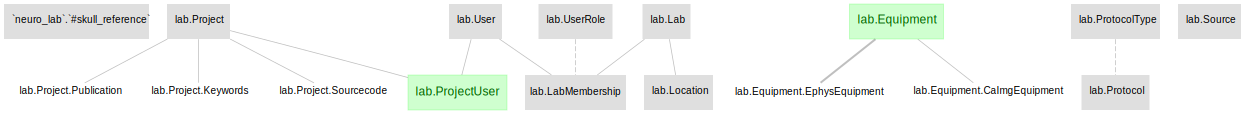

In [6]:
dj.Diagram(lab)

In [7]:
subject.Subject()

subject,sex,subject_birth_date,subject_description
subject1,M,2020-12-30,test animal
subject2,F,2020-11-30,test animal
subject3,F,2020-12-30,test animal
subject4,M,2021-02-12,test animal
subject5,F,2020-01-03,lmash_E105
subject6,M,2020-01-03,hneih_E105
subject7,U,2020-08-30,test animal
subject8,F,2020-09-30,test animal


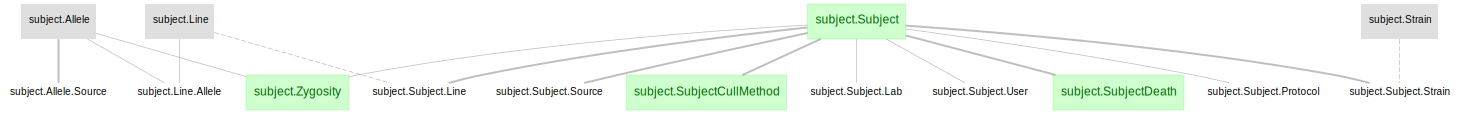

In [8]:
dj.Diagram(subject)

In [9]:
session.Session()

subject,session_datetime
subject3,2021-04-30 12:22:15.032000
subject5,2020-04-15 11:16:38
subject6,2021-01-15 11:16:38
subject6,2021-06-02 14:04:22


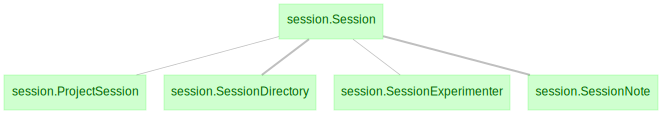

In [10]:
dj.Diagram(session)

(Workflow needs continued development to import geotyping tables)

## Explore each table

In [12]:
# check table definition with describe()
subject.Subject.describe()

# Animal Subject
subject              : varchar(32)                  
---
sex                  : enum('M','F','U')            
subject_birth_date   : date                         
subject_description="" : varchar(1024)                



'# Animal Subject\nsubject              : varchar(32)                  \n---\nsex                  : enum(\'M\',\'F\',\'U\')            \nsubject_birth_date   : date                         \nsubject_description="" : varchar(1024)                \n'

## Insert data into Manual and Lookup tables

Tables in this workflow are either manual tables or lookup tables. To insert into these tables, DataJoint provide method `.insert1()` and `insert()`.

In [15]:
subject.Subject.insert1(
    dict(subject='subject1', sex='M', subject_birth_date='2020-12-30', 
         subject_description='test animal'), skip_duplicates=True)
subject.Subject.insert1(
    ('subject2', 'F', '2020-11-30', 'test animal'), skip_duplicates=True)

`skip_duplicates=True` will prevent an error if you already have data for the primary keys in a given entry.

In [16]:
subject.Subject()

subject,sex,subject_birth_date,subject_description
subject1,M,2020-12-30,test animal
subject2,F,2020-11-30,test animal
subject3,F,2020-12-30,test animal
subject4,M,2021-02-12,test animal
subject5,F,2020-01-03,lmash_E105
subject6,M,2020-01-03,hneih_E105
subject7,U,2020-08-30,test animal
subject8,F,2020-09-30,test animal


In [17]:
# `insert()` takes a list of dicts or tuples
subject.Subject.insert(
    [dict(subject='subject3', sex='F', subject_birth_date='2020-12-30', 
            subject_description='test animal'),
     dict(subject='subject4', sex='M', subject_birth_date='2021-02-12', 
          subject_description='test animal')
    ],
    skip_duplicates=True)
subject.Subject.insert(
    [
        ('subject7', 'U', '2020-08-30', 'test animal'),
        ('subject8', 'F', '2020-09-30', 'test animal')
    ],
    skip_duplicates=True)

In [18]:
subject.Subject()

subject,sex,subject_birth_date,subject_description
subject1,M,2020-12-30,test animal
subject2,F,2020-11-30,test animal
subject3,F,2020-12-30,test animal
subject4,M,2021-02-12,test animal
subject5,F,2020-01-03,lmash_E105
subject6,M,2020-01-03,hneih_E105
subject7,U,2020-08-30,test animal
subject8,F,2020-09-30,test animal


For more documentation of insert, please refer to [DataJoint Docs](https://docs.datajoint.io/python/manipulation/1-Insert.html) and [DataJoint playground](https://playground.datajoint.io/)

## Insert into Manual and Lookup tables with Graphical User Interface

DataJoint also provides a Graphical User Interface [DataJoint Labbook](https://github.com/datajoint/datajoint-labbook) to support manual data insertions into DataJoint workflows. ![DataJoint Labbook preview](../images/DataJoint_Labbook.png)